# Model Selection

This purpose of this notebook is to determine which model to use for the spoiler detector.

## Use case

The ultimate use case for this model is to use it in a browser extension to classify and filter spoilers from a webpage. Thus, the model needs to be able to make fast classifications and should shoot for very few false negatives, meaning that the classifier should err on the side of spoiler over non-spoiler.

# Cleaning the Data

In order to clean the data, we will declare a helper function:

In [1]:
from string import punctuation
import re

# Standardize a given text field
def standardize_text(df, text_field):
    df[text_field] = df[text_field].replace(r"http\S+", "") # Remove link beginnings
    df[text_field] = df[text_field].replace(r"http", "") # Remove other links
    df[text_field] = df[text_field].replace(r"@\S+", "") # Remove twitter mentions
    df[text_field] = re.sub("[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", df[text_field]) # Replace non-standard characters with a space
    df[text_field] = df[text_field].replace(r"@", "at") # Replace @ symbols
    df[text_field] = df[text_field].replace(r"&", "and") # Replace & symbols
    df[text_field] = "".join(c for c in df[text_field] if c not in punctuation) # Remove punctuation
    #df[text_field] = re.sub('\d+', '{number}', df[text_field]) # Replace numbers
    df[text_field] = df[text_field].lower()
    return df

# Split by a delimiter starting from the back
def split_from_back(string, delimiter, limit=None):
    if not limit:
        return string.split(delimiter)
    
    reversed_str = string[::-1]
    split_rev_str = reversed_str.split(delimiter, maxsplit=limit)
    for index, element in enumerate(split_rev_str):
        split_rev_str[index] = split_rev_str[index][::-1]
        
    return split_rev_str[::-1]

## Perform the cleaning

In [2]:
import codecs
input_file_name = "data/train.balanced.csv"
output_file_name = "data/train.balanced.cleaned.csv"
input_file = codecs.open(input_file_name, "r",encoding='utf-8', errors='replace')
output_file = open(output_file_name, "w+")

for line in input_file:
    line = ','.join(standardize_text(split_from_back(line, ',', 4), 0))
    output_file.write(line)
input_file.close()
output_file.close()

# Data Prep
Tokenize the text and set up validation functions

In [3]:
from nltk.tokenize import RegexpTokenizer

# Tokenize strings
def tokenize(standardized_text_file):
    tokenizer = RegexpTokenizer(r'\w+')
    data = []
    with open(standardized_text_file, 'r') as f:
        for line in f:
            line = line.split(',')[:2]
            line[0] = tokenizer.tokenize(line[0])
            data.append(line)
    data = data[1:]

    new_data = []
    # Remove invalid rows
    for row in data:
        if len(row) == 2:
            new_data.append(row)

    data = new_data

    # Transform classes into numbers
    for row in data:
        if row[1] == 'True':
            row[1] = 1
        else:
            row[1] = 0
            
    return data

In [4]:
data = tokenize(output_file_name)

In [5]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Obtained LSA code from https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        feat_lsa = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        colors = ['orange','blue']
        if plot:
            plt.figure(figsize=(10, 10))
            plt.scatter(feat_lsa[:,0], feat_lsa[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Non-spoiler')
            blue_patch = mpatches.Patch(color='blue', label='Spoiler')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

In [6]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold as strat

# Create a function to perform 10 fold cross validation
# Returns the average accuracy across the 10 folds, the test class for each data point, and the resulting class for each data point
def validate(classifier, feat, classes):
    # create the 10 folds in the dataset
    skf = strat(n_splits=10, shuffle=True)
    skf.get_n_splits(feat, classes)
    
    fold = 0
    accuracy_sum = 0
    precision_sum = 0
    recall_sum = 0
    y_test_total = np.empty(shape=0)
    res_total = np.empty(shape=0)
    for train_index, test_index in skf.split(feat, classes):
        fold += 1
        # get test and training data for classes and feature arrays
        x_train, x_test = feat[train_index], feat[test_index]
        y_train, y_test = classes[train_index], classes[test_index]

        # train classifier
        classifier.fit(x_train, y_train)
        res = classifier.predict(x_test)

        # check accuracy of results
        classifier_correct = 0
        for i in range(len(res)):
            if res[i] == y_test[i]:
                classifier_correct += 1
        classifier_acc = float(classifier_correct)/float(len(res))
        accuracy_sum += classifier_acc
        precision_sum += precision_score(y_test, res)
        recall_sum += recall_score(y_test, res)
        y_test_total = np.concatenate((y_test_total, y_test))
        res_total = np.concatenate((res_total, res))
    return ((accuracy_sum / float(10)), (precision_sum / float(10)), (recall_sum / float(10)), y_test_total, res_total)

In [7]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# Obtained Confusion Matrix code from https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
def plot_confusion_matrix(y_test, y_predicted, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    
    cm = confusion_matrix(y_test, y_predicted)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

## Perform more inspection on the data

In [8]:
all_words = [word for sequence in data for word in sequence[0]]
num_spoilers = len(list(filter(lambda x: x[1] == 1, data)))
VOCAB = sorted(list(set(all_words)))
sentence_lengths = [len(sequence[0]) for sequence in data]
print("%s data points total" % (len(data)))
print("{} Spoilers, {} Non-spoilers".format(num_spoilers, len(data) - num_spoilers))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

11971 data points total
6288 Spoilers, 5683 Non-spoilers
236525 words total, with a vocabulary size of 19996
Max sentence length is 159


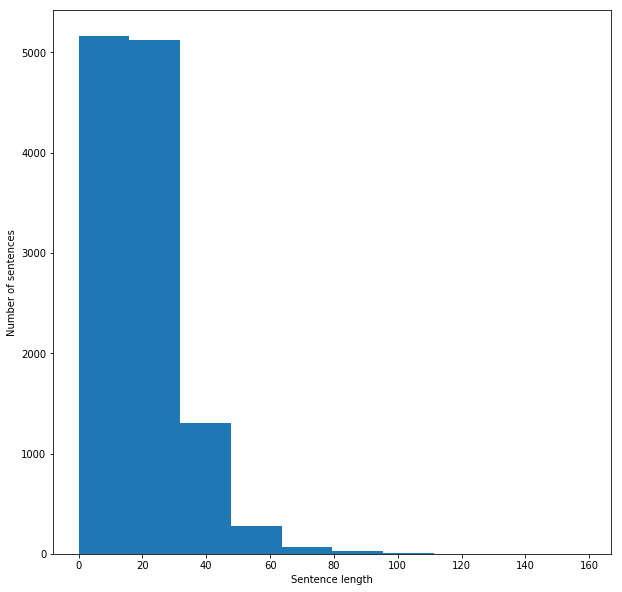

In [9]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

# Embedding (Bag of Words)

In [10]:
import numpy as np
def binary_search(alist, item):
    first = 0
    last = len(alist)-1
    found = False

    while first<=last and not found:
        midpoint = (first + last)//2
        if alist[midpoint] == item:
            return midpoint
        else:
            if item < alist[midpoint]:
                last = midpoint-1
            else:
                first = midpoint+1

    return -1

def row_to_BOW(row):
    BOW = [0 for word in VOCAB]
    for word in row:
        index = binary_search(VOCAB, word)
        BOW[index] += 1
    return BOW

def bag_of_words(data):
    word_bags = []
    classes = []
    for row in data:
        word_bags.append(row_to_BOW(row[0]))
        classes.append(row[1])
        
    return (np.asarray(word_bags), np.asarray(classes))

In [11]:
features, classes = bag_of_words(data)

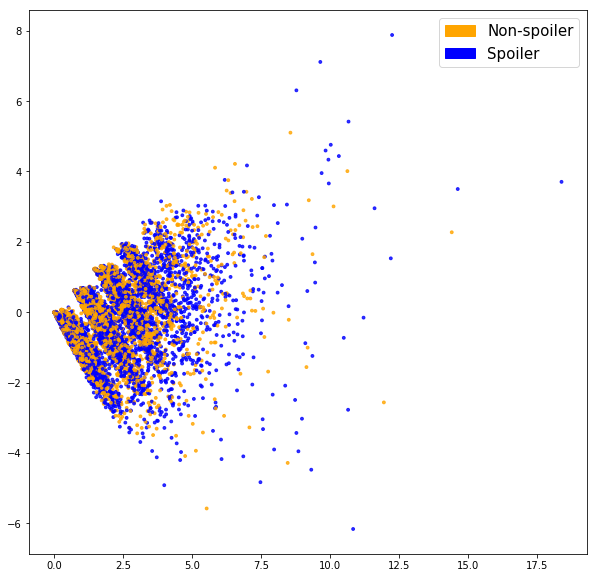

In [12]:
plot_LSA(features, classes)
plt.show()

There isn't much separation between the classes, but let's try to fit a classifier

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
accuracy, precision, recall, true_labels, pred_labels = validate(model, features, classes)
print("accuracy = {}, precision = {}, recall = {}".format(round(accuracy, 3), round(precision, 3), round(recall, 3)))

accuracy = 0.667, precision = 0.682, recall = 0.685


In our case, precision is the ability of our classifier to correctly identify non-spoilers, and recall is that ability of our classifier to correctly label spoilers as spoilers.
We are looking to maximize our recall, because it's acceptable for us to misidentify non-spoilers, but not to misidentify spoilers.

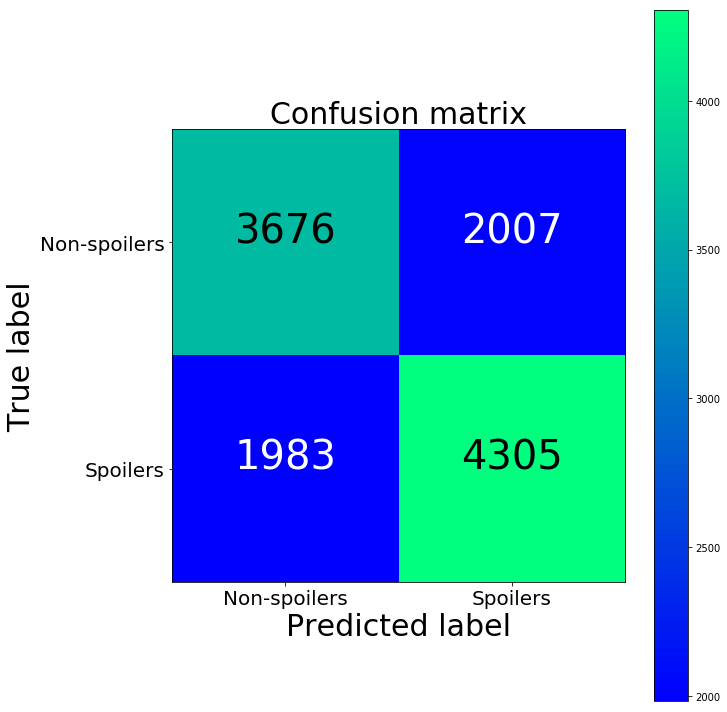

In [14]:
plot_confusion_matrix(true_labels, pred_labels, ['Non-spoilers', 'Spoilers'])
plt.show()

Still about 2000 false negatives. Not acceptable performance.

## Find Relevant Words

In [15]:
import heapq

# Takes a 2-tuple with the first element being the priority
def find_top_n_values(vals, n=10, largest=True):
    if largest:
        vals = [(-1*x[0], x[1]) for x in vals]
        
    heapq.heapify(vals)
    
    results = []
    for i in range(n):
        results.append(heapq.heappop(vals)[1])
        
    return results

In [16]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Non-spoiler', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Spoiler', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

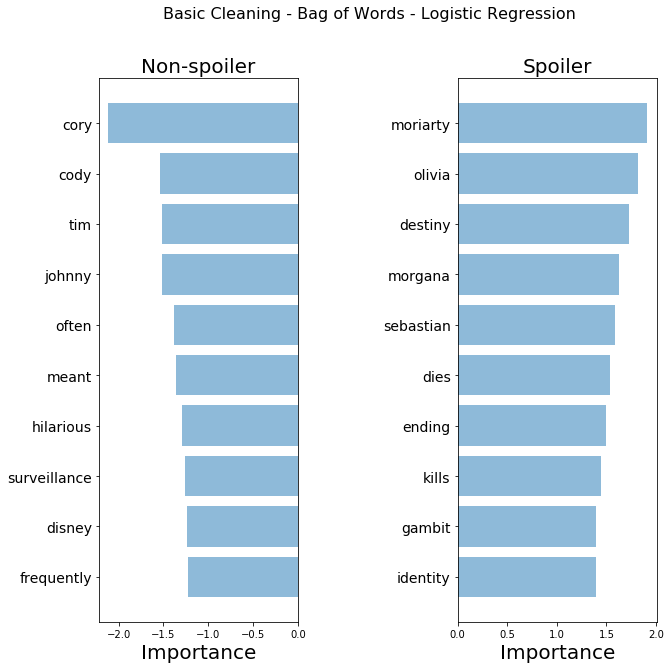

In [17]:
coefs = model.coef_[0]
pairs = []
for index, coef in enumerate(coefs):
    pairs.append((coef, (index, coef)))
    
largest = find_top_n_values(pairs, largest=True)
smallest = find_top_n_values(pairs, largest=False)

largest_scores = []
largest_words = []
smallest_scores = []
smallest_words = []
for elem in largest:
    largest_scores.append(elem[1])
    largest_words.append(VOCAB[elem[0]])
for elem in smallest:
    smallest_scores.append(elem[1])
    smallest_words.append(VOCAB[elem[0]])
    
plot_important_words(largest_scores, largest_words, smallest_scores, smallest_words, "Basic Cleaning - Bag of Words - Logistic Regression")

These results are interesting to look at. It makes sense that an indication of a spoiler would be names like Morgana, Olivia, Moriarty, etc. but there are also names on the other side like Cory, Tim, and Johnny. The other words on the non-spoiler side make sense to me. Marvelous is an interesting word to see on the spoiler side. In the data, the word 'destiny' is most often used as a proper noun, whether as the name of a person or part of a title rather than meaning someone's 'destiny'.

Looking at the data, names may not be a good indication at all one way or the other. Sometimes the names found in the data set are names of the actors, while other times they are names of the characters. I think it may be good to do some further investigation into the role that names play in the data, and maybe remove names in the cleaning phase.

# Removing names
We are going to use NLTK's Named Entity Recognizer to remove the names of people from the data

In [18]:
from nltk import word_tokenize
from nltk.tag.stanford import StanfordNERTagger

st = StanfordNERTagger('./stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz', './stanford-ner/stanford-ner.jar')

def remove_names_from_list(df, text_field):
    sentences = [x[text_field] for x in df]
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = st.tag_sents(tokenized_sentences)
    print(tagged_sentences)
    
    for sentence_index, tagged_sentence in enumerate(tagged_sentences):
        new_sentence_list = []
        for tag_index, tag in enumerate(tagged_sentence):
            if tag[1] == "PERSON" and tag_index != len(tagged_sentence)-1 and tagged_sentence[tag_index+1][1] == "PERSON":
                continue
                
            elif tag[1] == "PERSON":
                new_sentence_list.append("<name>")
                continue
                
            elif tag[0] == "'s":
                continue
    
            new_sentence_list.append(tag[0])
    
        df[sentence_index][text_field] = ' '.join(new_sentence_list)
        
    return df

/home/ryan/.virtualenvs/victor/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [19]:
output_file_name = "data/train.balanced.cleaned.names_removed.csv"
input_file = codecs.open(input_file_name, "r",encoding='utf-8', errors='replace')
output_file = open(output_file_name, "w+")

data = []
for line in input_file:
    split_line = split_from_back(line, ',', 4)
    split_line[0] = re.sub(r"'", "", split_line[0])
    data.append(split_line)
input_file.close()

name_removed_data = remove_names_from_list(data, 0)

for split_line in name_removed_data:
    line = ','.join(standardize_text(split_line, 0))
    output_file.write(line)
output_file.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
data = tokenize(output_file_name)

## Perform more inspection on the data

In [21]:
all_words = [word for sequence in data for word in sequence[0]]
num_spoilers = len(list(filter(lambda x: x[1] == 1, data)))
VOCAB = sorted(list(set(all_words)))
sentence_lengths = [len(sequence[0]) for sequence in data]
print("%s data points total" % (len(data)))
print("{} Spoilers, {} Non-spoilers".format(num_spoilers, len(data) - num_spoilers))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

11971 data points total
6288 Spoilers, 5683 Non-spoilers
234470 words total, with a vocabulary size of 17640
Max sentence length is 158


Something interesting happened here. The total words should have decreased, but instead it increased by 3000, and the max sentence length increased by 2 words. Interesting...

I realized that the apostrophes were messing up the named entity recognition and creating new words because of how the algorithm was tokenizing them, so I decided to preemptively remove all apostrophes, which gives results more along the lines of what we'd expect to see when removing names

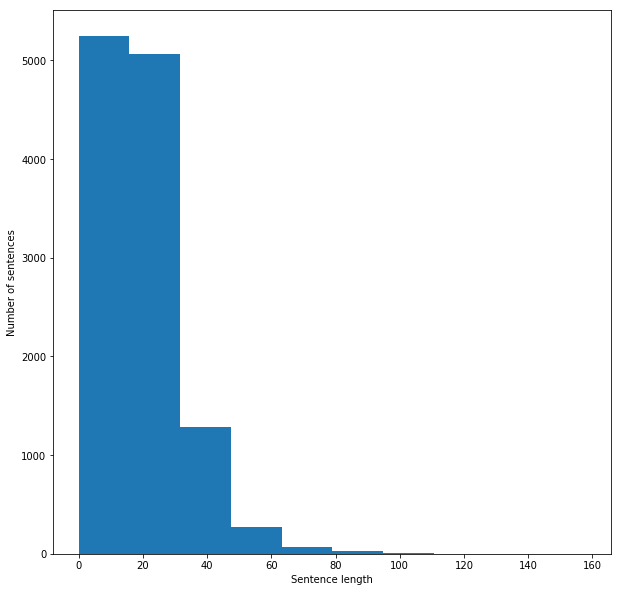

In [22]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Way more 0-20, which makes sense since we are trying to remove some words by removing names

## Bag of words embedding

In [23]:
features, classes = bag_of_words(data)

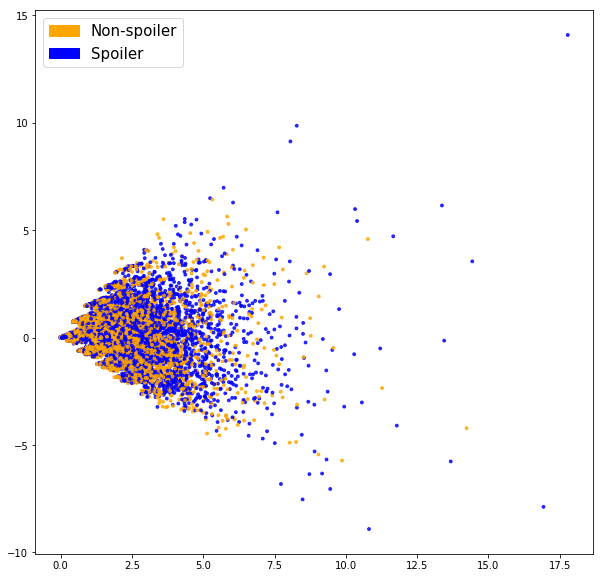

In [24]:
plot_LSA(features, classes)
plt.show()

Based on this graph, removing the names may very well have been a step backwards. Let's fit a classifier to find out.

In [25]:
model = LogisticRegression()
accuracy, precision, recall, true_labels, pred_labels = validate(model, features, classes)
print("accuracy = {}, precision = {}, recall = {}".format(round(accuracy, 3), round(precision, 3), round(recall, 3)))

accuracy = 0.656, precision = 0.672, recall = 0.675


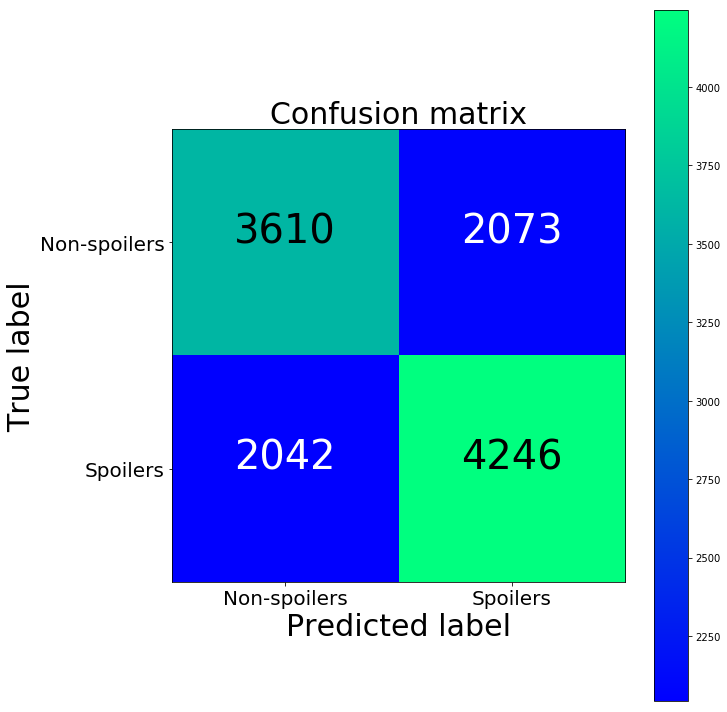

In [26]:
plot_confusion_matrix(true_labels, pred_labels, ['Non-spoilers', 'Spoilers'])
plt.show()

This classifier performed worse in seemingly every area, reducing both accuracy and recall, and increasing both false-positives and false-negatives. Let's look at the key words though, just to see what's going on under the hood.

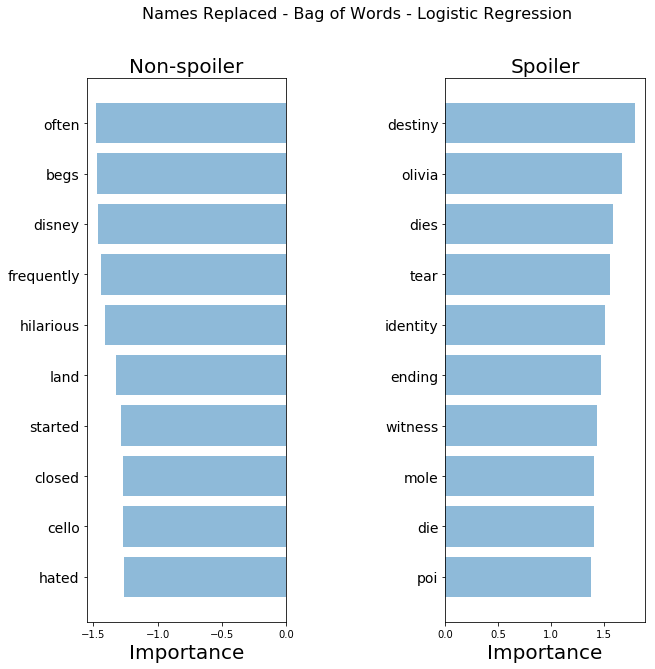

In [27]:
coefs = model.coef_[0]
pairs = []
for index, coef in enumerate(coefs):
    pairs.append((coef, (index, coef)))
    
largest = find_top_n_values(pairs, largest=True)
smallest = find_top_n_values(pairs, largest=False)

largest_scores = []
largest_words = []
smallest_scores = []
smallest_words = []
for elem in largest:
    largest_scores.append(elem[1])
    largest_words.append(VOCAB[elem[0]])
for elem in smallest:
    smallest_scores.append(elem[1])
    smallest_words.append(VOCAB[elem[0]])
    
plot_important_words(largest_scores, largest_words, smallest_scores, smallest_words, "Names Replaced - Bag of Words - Logistic Regression")

The named entity recognition seems to have missed some of the names by including olivia and sydney. After looking at the data, I've discovered that the new words result from spaces being added between a word and it's posessive 's' (for example, during cleaning, instead of Olivia's becoming olivias, it becomes olivia s). I need to formulate a way to clean the data so that it gets names that have apostrophes and s's at the end.

After going back and editing the tokenization and named entity recognition, we seem to be getting better results. Even though the model performed slightly worse, the words we're getting seem to make much more sense. The non-spoiler words indicate either opinion or something happening frequently, whereas the spoiler words indicate common plot twists, such as death, someone being a mole, or the ending of a movie or show.

We still have a fair amount of "olivia"'s in the data, and I think that is simply the fault of the named entity recognizer not performing well on the name "olivia"

# TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

def tfidf(data):
    documents = [' '.join(x[0]) for x in data]
    classes = [x[1] for x in data]
    
    return (tfidf_vectorizer.fit_transform(documents), np.asarray(classes))

In [36]:
data = tokenize(output_file_name)
features, classes = tfidf(data)

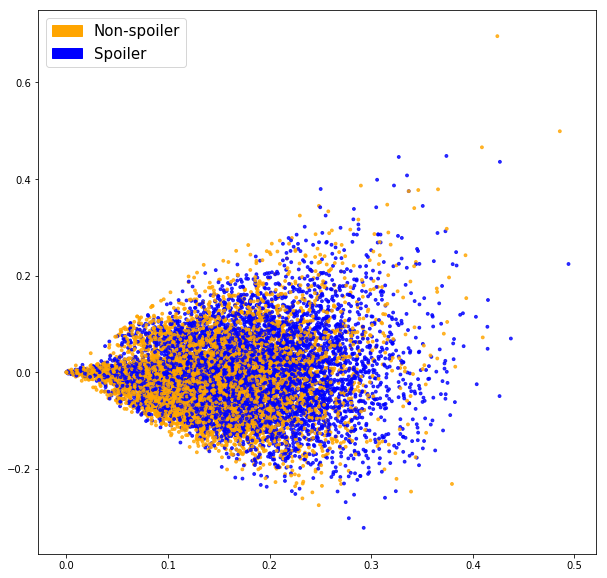

In [37]:
plot_LSA(features, classes)
plt.show()

In [38]:
model = LogisticRegression()
accuracy, precision, recall, true_labels, pred_labels = validate(model, features, classes)
print("accuracy = {}, precision = {}, recall = {}".format(round(accuracy, 3), round(precision, 3), round(recall, 3)))

accuracy = 0.675, precision = 0.685, recall = 0.705


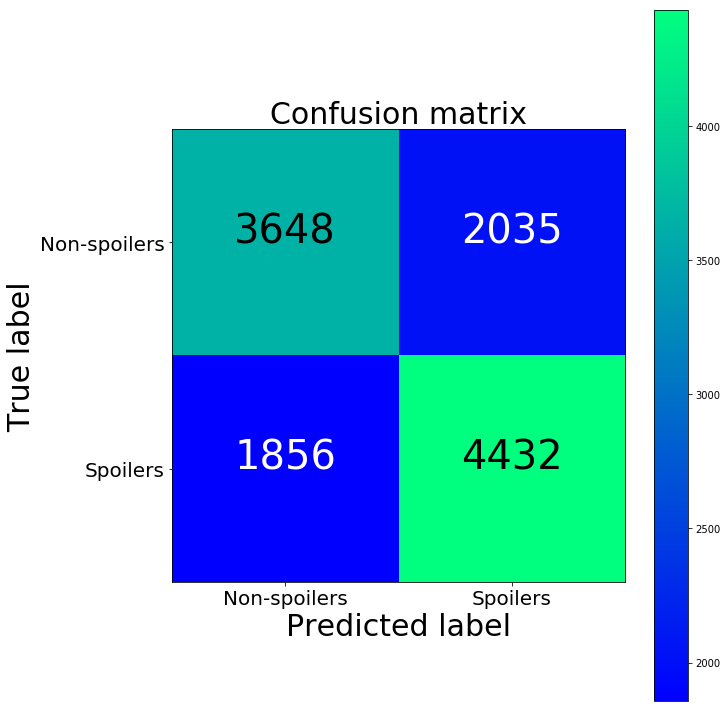

In [39]:
plot_confusion_matrix(true_labels, pred_labels, ['Non-spoilers', 'Spoilers'])
plt.show()

Slight boost in accuracy over past model and fairly large jump in recall. This is the best recall we've seen yet, which bodes well for this model. Let's examine the key words

## View important words for this model

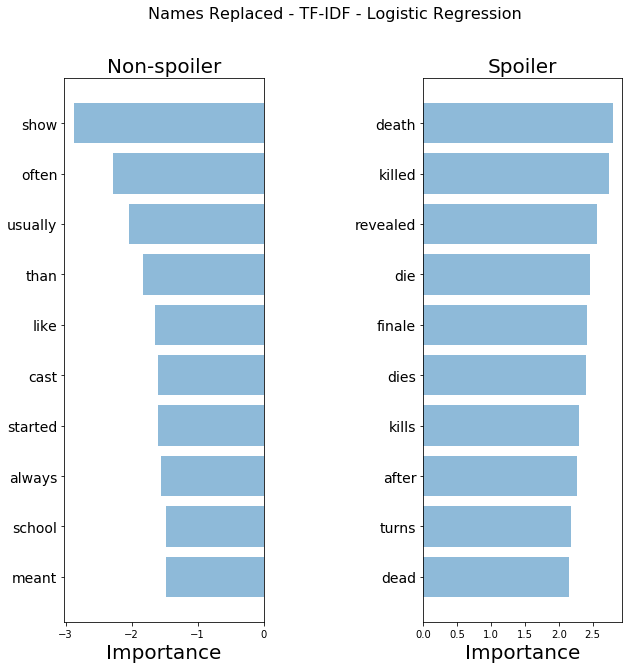

In [40]:
index_to_word = {v:k for k,v in tfidf_vectorizer.vocabulary_.items()}

coefs = model.coef_[0]
pairs = []
for index, coef in enumerate(coefs):
    pairs.append((coef, (index, coef)))
    
largest = find_top_n_values(pairs, largest=True)
smallest = find_top_n_values(pairs, largest=False)

largest_scores = []
largest_words = []
smallest_scores = []
smallest_words = []
for elem in largest:
    largest_scores.append(elem[1])
    largest_words.append(index_to_word[elem[0]])
for elem in smallest:
    smallest_scores.append(elem[1])
    smallest_words.append(index_to_word[elem[0]])
    
plot_important_words(largest_scores, largest_words, smallest_scores, smallest_words, "Names Replaced - TF-IDF - Logistic Regression")

Based on these results, it appears the model does a better job at determining spoilers (which is backed up by what we saw with the improved recall). All of the top 10 words indicate what we think of as a traditional spoiler, with people dying and killing. The non-spoiler side makes a little less sense. it includes some words that make sense, like show, often, usually, cast, and always, but it also includes words that don't make as much sense, like school and than.

I think the next step will be trying to clean up the data a little bit more by removing stop words and performing stemming/lemmatization